<a href="https://colab.research.google.com/github/lizliu2015/NLP-frequently-used-code/blob/main/score_toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents

1.   Configuring TPU's
2.   Simple RNN
3.   Word Embeddings
4.   LSTM's
5.   Code Implementation
6.   GRU's
7.   Bi-Directional RNN's
8.   Seq2Seq Model Architecture
9.   Attention Models
10.  Transformers 
11.  BERT 

https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert/notebook#Word-Embeddings

https://www.kaggle.com/code/rftexas/nlp-cheatsheet-master-nlp/notebook




In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [4]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/file/d/link=1MCre5qWf_-ZMCCfLDqe-8uQo7B6YvxcX' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1MCre5qWf_-ZMCCfLDqe-8uQo7B6YvxcX


In [6]:
id = '1MCre5qWf_-ZMCCfLDqe-8uQo7B6YvxcX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('jigsaw-toxic-comment-train.csv')  
train = pd.read_csv('jigsaw-toxic-comment-train.csv')
# Dataset is now stored in a Pandas Dataframe

In [7]:
id = '1-kxpsFCxookY1ZGZdu4EFTWaD6YEAnzx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('validation.csv')  
validation = pd.read_csv('validation.csv')

In [8]:
id = '1_esHiKpTPwD6AlD8DVBdySN4zC0Syktu'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
test = pd.read_csv('test.csv')

# Configure TPU

In [9]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [10]:
# We will drop the other columns and approach this problem as a Binary Classification Problem 
# and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)
train = train.loc[:12000,:]
train.shape

(12001, 3)

In [11]:
#We will check the maximum number of words that can be present in a comment , this will help us in padding later
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [12]:
#Writing a function for getting auc score for validation
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


In [13]:
#data preparation
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# EDA

In [32]:
#take a peak
train.tail(10)

,id,comment_text,toxic
11991,1fbe9c3cf406e12b,Suggestion \n\nPlease stop trying to act like ...,0
11992,1fbf6d04d85510a7,Color \n\nIt used to be black. When was it rep...,0
11993,1fc0f8e5a4ba1f9d,"No, it was said in ep. 26. 76.95.66.209",0
11994,1fc189821a287b26,"""\n\nRegarding text formatting, I'm talking ab...",0
11995,1fc1b4d6b088341a,Greek primacy\nI'm in two minds myself. But Ta...,0
11996,1fc25487b9b9187f,February 2006 (UTC)\n\nThank you for fixing th...,0
11997,1fc3e5540e2605d1,Erased another silly message.,0
11998,1fc4c99c34cf0e07,"""\n\n Helly Jimmy, well; fuck you. \n\nAccordi...",1
11999,1fc8d9f16da8cccc,"Why don't you run cry to your mommy, little As...",1
12000,1fc9441f74fb9440,"""\n\nThat is not a list of official names of o...",0


In [33]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
#train["comment_text"].fillna("unknown", inplace=True)
#test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id              0
comment_text    0
toxic           0
dtype: int64
Check for missing values in Test dataset
id         0
content    0
lang       0
dtype: int64
filling NA with "unknown"


In [34]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 12001 : 63812
perc   : 16    : 84


In [35]:
#class imbanlance
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  12001
Total clean comments =  10865
Total tags = 1136


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


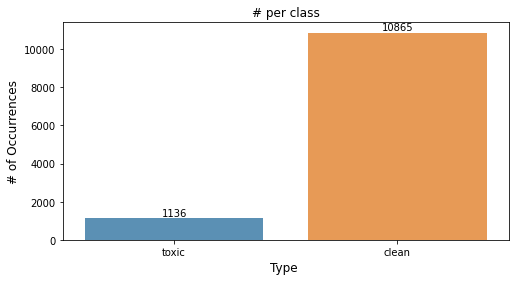

In [36]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# RNN

Explaination of RNN: https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/

Documentation: https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html

Coursera NLP using Tensorflow: https://www.coursera.org/learn/natural-language-processing-tensorflow/home/welcome


## tokenizing & Padding
In an RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1.
What keras Tokenizer does is , it takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now

## padding
First, in order to use the padding functions you'll have to import pad sequences from tensorflow.keras.preprocessing.Sequence. Then once the tokenizer has created the sequences, these sequences can be passed to pad sequences in order to have them padded like this. The result is pretty straight forward. You can now see that the list of sentences has been padded out into a matrix and that each row in the matrix has the same length. It achieved this by putting the appropriate number of zeros before the sentence.

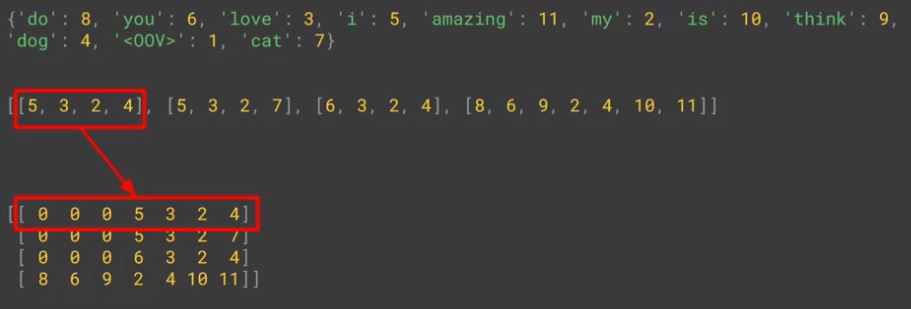

In [14]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

## Simple RNN

In [40]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13,089,301
Trainable params: 13,089,301
Non-trainable params: 0
_________________________________________________________________
CPU times: user 348 ms, sys: 126 ms, total: 474 ms
Wall time: 575 ms


In [41]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

Epoch 1/5
150/150 [==============================] - 205s 1s/step - loss: 0.3401 - accuracy: 0.8853
Epoch 2/5
150/150 [==============================] - 199s 1s/step - loss: 0.2353 - accuracy: 0.9114
Epoch 3/5
150/150 [==============================] - 208s 1s/step - loss: 0.0958 - accuracy: 0.9668
Epoch 4/5
150/150 [==============================] - 225s 2s/step - loss: 0.0207 - accuracy: 0.9952
Epoch 5/5
150/150 [==============================] - 223s 1s/step - loss: 0.0033 - accuracy: 0.9997


In [42]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.85%


In [43]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

## Word Embeddings
explaination :https://machinelearningmastery.com/what-are-word-embeddings/

deeplearning.ai course: https://www.coursera.org/learn/nlp-sequence-models/lecture/6Oq70/word-representation



In [ ]:
id = '1gxu1M6umXsCBW8pBesRVVf9ZlZUCj1fI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.840B.300d.txt')  

In [1]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

FileNotFoundError: ignored

## LSTM
explaination: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21



In [15]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43496/43496 [00:00<00:00, 679360.42it/s]


In [16]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13,209,601
Trainable params: 160,501
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 573 ms, sys: 144 ms, total: 717 ms
Wall time: 1.04 s


In [18]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)


Epoch 1/5
 79/150 [==============>...............] - ETA: 7:57 - loss: 0.3734 - accuracy: 0.9062

KeyboardInterrupt: ignored

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})


## GRU
Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

Explaination: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be


In [ ]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)


In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,yvalid)})


In [ ]:
scores_model


## Bi-Directional RNN's

Explaination:

https://www.coursera.org/learn/nlp-sequence-models/lecture/fyXnn/bidirectional-rnn

https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66

https://d2l.ai/chapter_recurrent-modern/bi-rnn.html


In [ ]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)


In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})


# Seq2Seq Model Architecture


In [ ]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =results.Model,
    values = results.AUC_Score,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Attention Model


# Transformer


# BERT


In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
# LOADING THE DATA

train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)